In [95]:
import pandas as pd
import nltk
import numpy as np
import seaborn as sns
import matplotlib as plt
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from nltk.corpus import stopwords
from funciones_aux import *

Aqui utilizamos el archivo train_limpio.csv que es el train.csv pero filtrado sacando reseñas que no estaban en español

In [96]:
df_train = pd.read_csv("train_limpio.csv")
df_test = pd.read_csv("test.csv")

In [97]:
RUTA_GUARDADO = "predicciones.csv"

In [98]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           50000 non-null  int64 
 1   review_es    50000 non-null  object
 2   sentimiento  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


Aqui ya observamos que el dataset no contiene nulos

<Axes: xlabel='sentimiento', ylabel='count'>

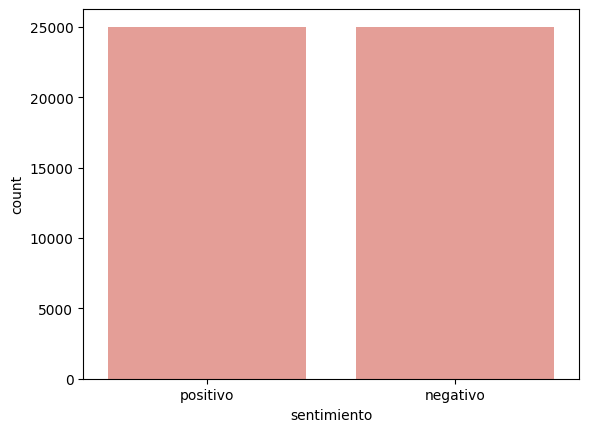

In [99]:
sns.countplot(x=df_train["sentimiento"], color="#F1948A")

In [100]:
df_train["sentimiento"].value_counts()

sentimiento
positivo    25000
negativo    25000
Name: count, dtype: int64

In [101]:
df_train["sentimiento"] = df_train["sentimiento"].map({"positivo": 1, "negativo": 0})

In [103]:
#df_train["review_es"], df_test["review_es"] = normalizar_texto(df_train, "review_es"), normalizar_texto(df_test, "review_es")

In [104]:
df_train["review_es"], df_test["review_es"] = df_train["review_es"].str.lower(), df_test["review_es"].str.lower()

In [105]:
df_train_train, df_train_test = train_test_split(df_train, test_size=0.3, random_state=33)

In [106]:
x_train, y_train, x_test_, y_test_ = df_train_train["review_es"], df_train_train["sentimiento"], df_train_test["review_es"], df_train_test["sentimiento"]

In [107]:
x_test = df_test["review_es"]

In [108]:
from sklearn.model_selection import GridSearchCV

In [109]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

In [110]:
def imprimir_resultados(y, y_pred):

    labels = [0, 1]

    f1 = f1_score(y, y_pred, pos_label=1, labels=labels)
    precision = precision_score(y, y_pred, pos_label=1, labels=labels)
    recall = recall_score(y, y_pred, pos_label=1, labels=labels)
    accuracy = accuracy_score(y, y_pred)

    cm = confusion_matrix(y_test_, y_pred)

    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

    print(f"F1: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")

In [111]:
def guardar_resultado_en_csv(prediccion):

    prediccion = np.where(prediccion == 0, "negativo", "positivo")

    df_predicciones = pd.DataFrame({"ID": df_test["ID"], "prediccion": prediccion})

    df_predicciones.to_csv(RUTA_GUARDADO, header=["ID", "sentimiento"], index=False)

In [112]:
vectorizer = CountVectorizer()
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test_)

## Bernoulli Naive Bayes

In [113]:
def busqueda_hiperparametros_nb(modelo, x_vectorizado):
  param_grid = {
    "alpha": [0.6, 0.7, 0.8],
    "binarize": [0.0],
    "fit_prior": [True],
    "class_prior": [[0.2,0.6], [0.1,0.5], [0.2,0.7]]
  }
  
  grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid, cv=10, scoring="f1_macro")
  
  grid_search.fit(x_vectorizado, y_train)

  return grid_search

In [114]:
# Dejando stopwords

nb_classifier = BernoulliNB()
gs = busqueda_hiperparametros_nb(nb_classifier, x_train_vec)

In [115]:
print(gs.best_params_)

{'alpha': 0.8, 'binarize': 0.0, 'class_prior': [0.1, 0.5], 'fit_prior': True}


In [116]:
best_nb = BernoulliNB(alpha=gs.best_params_["alpha"], fit_prior=gs.best_params_["fit_prior"])

gs.fit(x_train_vec, y_train)
y_pred_nb = gs.predict(x_test_vec)

F1: 0.8535300316122234
Precision: 0.8393782383419689
Recall: 0.8681672025723473
Accuracy: 0.8517333333333333


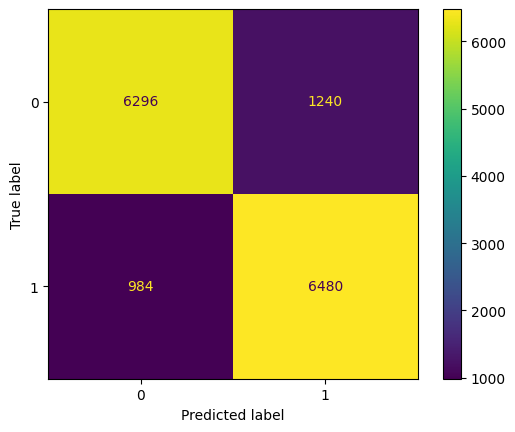

In [117]:
imprimir_resultados(y_test_, y_pred_nb)

In [118]:
y_pred_nb_ = gs.predict(vectorizer.transform(x_test))

In [119]:
guardar_resultado_en_csv(y_pred_nb_)

## Random Forest

In [120]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

In [121]:
def func_classif(param_distributions, cv, scoring, estimator, n_iter):
  randomcv = RandomizedSearchCV(estimator=estimator,
                                param_distributions = param_distributions,
                                scoring=scoring,
                                cv=cv,
                                n_jobs = -1,
                                n_iter=n_iter,
                                random_state=33)

  randomcv.fit(x_train_vec, y_train)

  return randomcv

In [122]:
n_iter = 5

param_distributions = { 
    "criterion" : ["gini", "entropy", "log_loss"],
    "min_samples_leaf" : [1, 5, 10],
    "min_samples_split" : [2, 4, 10, 12, 16],
    "n_estimators": [10, 20, 50, 70, 100],
    "max_depth": range(15, 50) }


cv = StratifiedKFold(n_splits=5)

scoring = "accuracy"

estimator = RandomForestClassifier(random_state=33)

randomcv = func_classif(param_distributions, cv, scoring, estimator, n_iter)

In [123]:
best_rf = randomcv.best_estimator_

In [124]:
best_params_rf = randomcv.best_params_

In [125]:
best_rf = RandomForestClassifier(
            criterion=best_params_rf["criterion"],
            min_samples_leaf=best_params_rf["min_samples_leaf"],
            min_samples_split=best_params_rf["min_samples_split"],
            n_estimators=best_params_rf["n_estimators"],
            max_depth=best_params_rf["max_depth"])

In [126]:
best_rf.fit(x_train_vec, y_train)

y_pred_rf = best_rf.predict(x_test_vec)

F1: 0.842346471127406
Precision: 0.8236875800256082
Recall: 0.8618703108252947
Accuracy: 0.8394666666666667


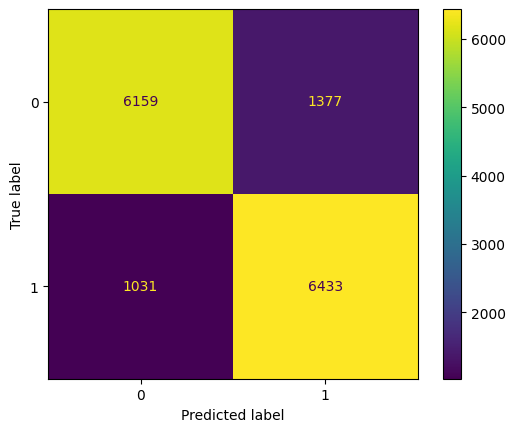

In [127]:
imprimir_resultados(y_test_, y_pred_rf)

In [128]:
y_pred_rf_ = best_rf.predict(vectorizer.transform(x_test))

In [129]:
guardar_resultado_en_csv(y_pred_rf_)

## XGBoost

In [130]:
from xgboost import XGBClassifier

In [131]:
n_iter = 5

param_distributions = { 
    "learning_rate": [0.01, 0.1, 0.2, 0.3, 0.4],
    "max_depth": [3, 4, 5, 7],
    "n_estimators": [100, 200, 300] 
    }

cv = StratifiedKFold(n_splits=5)

scoring = "accuracy"

estimator = XGBClassifier(random_state=33)

randomcv = func_classif(param_distributions, cv, scoring, estimator, n_iter)

In [132]:
best_params_xgboost = randomcv.best_params_

In [133]:
best_xgboost = XGBClassifier(learning_rate=best_params_xgboost["learning_rate"],
                        n_estimators=best_params_xgboost["n_estimators"],
                        max_depth=best_params_xgboost["max_depth"])

In [134]:
best_xgboost.fit(x_train_vec, y_train)

y_pred_xgboost = best_xgboost.predict(x_test_vec)

F1: 0.8641827721325629
Precision: 0.8568418279994732
Recall: 0.8716505894962486
Accuracy: 0.8636666666666667


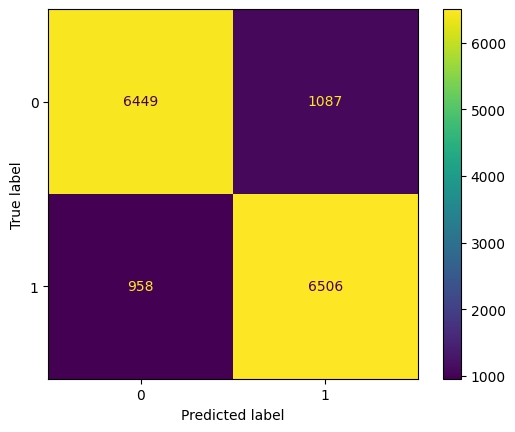

In [136]:
imprimir_resultados(y_test_, y_pred_xgboost)

In [137]:
y_pred_xgboost_ = best_xgboost.predict(vectorizer.transform(x_test))

In [138]:
guardar_resultado_en_csv(y_pred_xgboost_)

## Red neuronal

## Ensamble